In [8]:
%load_ext autoreload
%autoreload 2

import kagglehub

# Download chest x-ray (will take a minute or two)
data_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
train_path = data_path + "/chest_xray/train"
test_path = data_path + "/chest_xray/test"
val_path = data_path + "/chest_xray/test"

## Data Preprocessing

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Grayscale(), #compression 3 rgb matrix into one for runtime
    transforms.Resize((224, 224)), # can downsample here for runtime
    transforms.ToTensor(),
])

#Loading train, test, and validation datasets.
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform = transform)

#dataloaders w 32 images each for batches (randomized)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_dataset.classes) # classes for the data (train)

['NORMAL', 'PNEUMONIA']


### Test Visualization


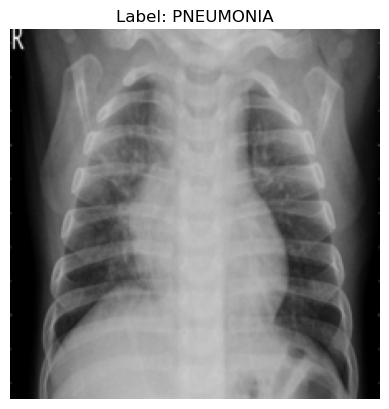

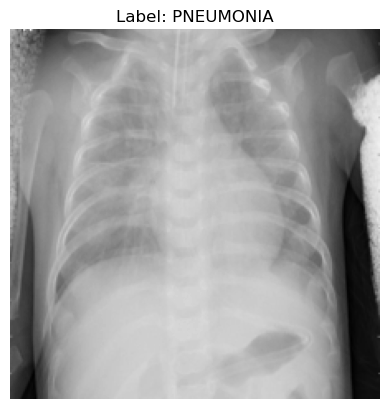

In [11]:
import matplotlib.pyplot as plt
import numpy as np

#image batch
dataiter = iter(train_loader)
images, labels = next(dataiter) #image, label pair


img_ten = images[0] #getting the 0th image/label pair
label = labels[0]

#tensor to NumPy (tensors no work for plotting :P)
img_np = img_ten.numpy()
img_np = np.transpose(img_np, (1, 2, 0))  #NOTE that the height/width need to be reordered when converting

#Image plot with the label on the top (thanks Chodrow!!!)
plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {train_dataset.classes[label]}")
plt.axis("off")
plt.show()

i=10
pnu_img_ten = images[i]

pnu_label = labels[i]

pnu_img_np = pnu_img_ten.numpy()
pnu_img_np = np.transpose(pnu_img_np, (1, 2, 0))

plt.imshow(pnu_img_np, cmap='gray')
plt.title(f"Label: {train_dataset.classes[pnu_label]}")
plt.axis('off')
plt.show()


In [12]:
#Image Dimension (for later)
pnu_img_ten.size()

torch.Size([1, 224, 224])

## Pneumonia Autoencoder

In [13]:
import torch.nn as nn
import torch
import torch.optim as optim
from PneumoniaAutoencoder import PneumoniaAutoencoder

# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #easy to switch between cpu and gpu
model = PneumoniaAutoencoder().to(device)

### Autoencoder training

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

from tqdm import tqdm

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # progress bar (really nice)
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for images, _ in pbar:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update bar
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

Epoch [1/1]: 100%|██████████| 163/163 [01:10<00:00,  2.31it/s, loss=0.00183]

Epoch [1/1], Avg Loss: 0.0132


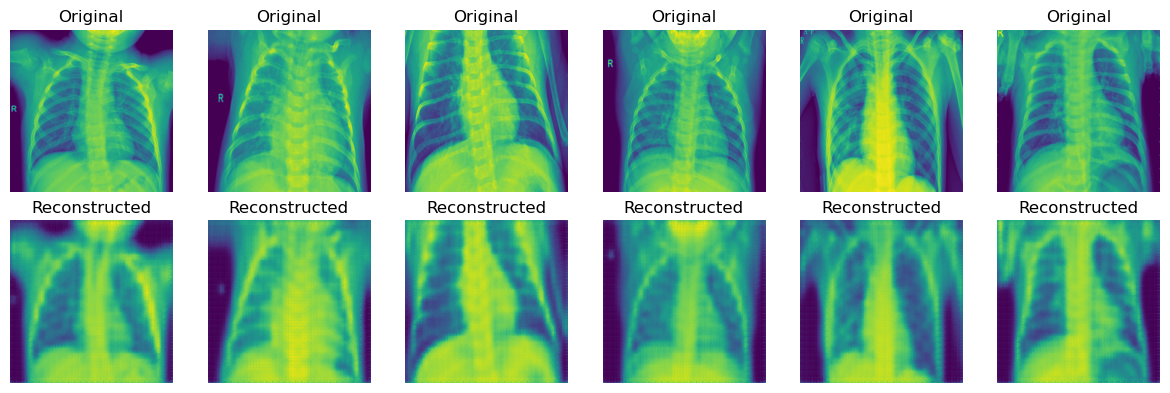

In [15]:
## reconstructed images

import matplotlib.pyplot as plt
import numpy as np

# eval
model.eval()

# batch
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)

# Reconstruct images
with torch.no_grad():
    reconstructions = model(images)

# Move tensors to CPU for plotting (np can't use gpu)
images = images.cpu()
reconstructions = reconstructions.cpu()

#transpose for tensor --> numpy
def tensor_to_img(t):
    t = t.numpy()
    t = np.transpose(t, (1, 2, 0))
    return t

# Plot original and reconstructed
n = 6 #num images
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tensor_to_img(images[i]))
    ax.set_title("Original")
    plt.axis("off")

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tensor_to_img(reconstructions[i]))
    ax.set_title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Autoencoder PCA plot 
This to check if differences encoded are meaningful.

In [16]:
model.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in train_loader:  # labels: 0=norm, 1=pneu
        images = images.to(device)
        encoded = model.encoder(images)
        # Flatten
        encoded = encoded.view(encoded.size(0), -1).cpu().numpy()
        latent_vectors.append(encoded)
        labels_list.append(labels.cpu().numpy())

# Stack into arrays
import numpy as np
X = np.vstack(latent_vectors)
y = np.hstack(labels_list)

from sklearn.decomposition import PCA

pca = PCA(n_components=2) #2 Principal components
X_pca = pca.fit_transform(X)

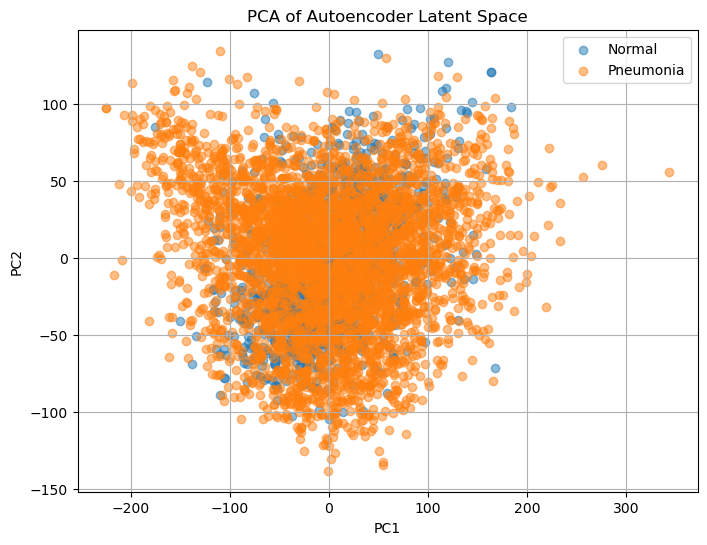

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], label="Normal", alpha=0.5)
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], label="Pneumonia", alpha=0.5)
plt.title("PCA of Autoencoder Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


## Variational AutoEncoder with Contrastive loss

In [18]:
# Contrastive loss function for VAE
def supervised_contrastive_loss(embeddings, labels: torch.Tensor, temperature=0.1):
    device = embeddings.device
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(device)

    dot_product = (embeddings @ embeddings.T) / temperature
    logits_max, _ = torch.max(dot_product, dim=1, keepdim=True)
    logits = dot_product - logits_max.detach()

    exp_logits = torch.exp(logits) * (1 - torch.eye(len(labels), device=device))
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-8)

    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
    loss = -mean_log_prob_pos.mean()
    return loss

In [19]:
def get_balanced_indices(labels):
    """Returns an equal number of positive and negative indices."""
    pos_indices = [i for i, y in enumerate(labels) if y == 1]
    neg_indices = [i for i, y in enumerate(labels) if y == 0]

    min_class_len = min(len(pos_indices), len(neg_indices))
    pos_sample = np.random.choice(pos_indices, min_class_len, replace=False)
    neg_sample = np.random.choice(neg_indices, min_class_len, replace=False)

    return np.concatenate([pos_sample, neg_sample])

In [20]:
import numpy as np
from sklearn.decomposition import PCA
from ContrastiveVAE import ContrastiveVAE
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

def train_vae(model_class, dataset, optimizer_class, device, epochs=10, beta=1.0, contrastive_weight=1.0):
    recon_loss_fn = nn.MSELoss(reduction='sum')
    k_folds = 5
    batch_size = 32
    kf = KFold(n_splits=k_folds, shuffle=True)

    all_labels = [label for _, label in dataset]
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f"\nFold {fold + 1}")
        print("-------")

        #Balanced sampling
        train_labels = [all_labels[i] for i in train_idx]
        balanced_indices = get_balanced_indices(train_labels)
        balanced_train_idx = [train_idx[i] for i in balanced_indices]

        #Loaders
        train_loader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=SubsetRandomSampler(balanced_train_idx),
        )
        test_loader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=SubsetRandomSampler(test_idx),
        )

        #model and optimizer
        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters())

        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()

                x_recon, mu, logvar = model(x)
                recon_loss = recon_loss_fn(x_recon, x) / x.size(0)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                contrastive = supervised_contrastive_loss(mu, y)

                loss = recon_loss + beta * kl_loss + contrastive_weight * contrastive
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f}")

        #test set evaluation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                x_recon, mu, logvar = model(x)
                recon_loss = recon_loss_fn(x_recon, x) / x.size(0)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                contrastive = supervised_contrastive_loss(mu, y)
                loss = recon_loss + beta * kl_loss + contrastive_weight * contrastive
                val_loss += loss.item()

        val_loss /= len(test_loader)
        print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}")
        fold_results.append(val_loss)

    print(f"\nAverage Validation Loss: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")
    return model #returning trained model

### Training ConstrastiveVAE

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = train_vae(
    model_class=lambda: ContrastiveVAE(latent_dim=64),
    dataset=train_dataset,
    optimizer_class=lambda params: torch.optim.Adam(params, lr=1e-3),
    device=device,
    epochs=1,
    beta=1.0,
    contrastive_weight=5.0
)



Fold 1
-------


Epoch 1/1: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]


Epoch 1 - Train Loss: 2160.0187
Fold 1 - Validation Loss: 982.7142

Fold 2
-------


Epoch 1/1: 100%|██████████| 67/67 [01:03<00:00,  1.06it/s]


Epoch 1 - Train Loss: 3410.5741
Fold 2 - Validation Loss: 1187.0069

Fold 3
-------


Epoch 1/1: 100%|██████████| 67/67 [00:56<00:00,  1.19it/s]


Epoch 1 - Train Loss: 90102.3584
Fold 3 - Validation Loss: 4483675.6667

Fold 4
-------


Epoch 1/1: 100%|██████████| 69/69 [00:55<00:00,  1.24it/s]


Epoch 1 - Train Loss: 2676.3448
Fold 4 - Validation Loss: 1174.3990

Fold 5
-------


Epoch 1/1: 100%|██████████| 67/67 [00:55<00:00,  1.21it/s]


Epoch 1 - Train Loss: 2540.2354
Fold 5 - Validation Loss: 1096.8304

Average Validation Loss: 897623.3234 ± 1793026.1731


In [22]:
import plotly.express as px

def plot_latent_space_3d(model, dataloader, device):
    model.eval()
    mus = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            x_recon, mu, logvar = model(x)
            mus.append(mu.cpu().numpy())
            labels.append(y.numpy())

    mus = np.concatenate(mus, axis=0)
    labels = np.concatenate(labels, axis=0)

    # PCA
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(mus)

    # pd.data.frame for plotly!
    import pandas as pd
    df = pd.DataFrame({
        'PC1': reduced[:, 0],
        'PC2': reduced[:, 1],
        'PC3': reduced[:, 2],
        'Label': labels
    })

    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                        color=df['Label'].astype(str),
                        title='3D PCA of Latent Space',
                        labels={'color': 'Class'},
                        opacity=0.7)
    fig.update_traces(marker=dict(size=4))
    fig.show()


In [23]:
plot_latent_space_3d(model, train_loader, device)

## Training and Classification with Muliple Modeles

### Train, Test Split

In [24]:
def extract_latent_vectors(model, dataloader, device):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu, _ = model.encode(x)
            all_mu.append(mu.cpu().numpy()) #add all into np array
            all_labels.append(y.numpy())

    X = np.concatenate(all_mu, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


In [25]:

X_train, y_train = extract_latent_vectors(model, train_loader, device)
X_test, y_test = extract_latent_vectors(model, test_loader, device)
# X_train.shape is (5216, 64)

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model_test = LogisticRegression(max_iter=100, verbose = 1)
model_test.fit(X_train, y_train)

y_pred = model_test.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred, digits=4))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           65     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  3.51967D-01

At iterate   50    f=  3.81556D-01    |proj g|=  1.99673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   65     77     86      1     0     0   9.536D-05   3.795D-01
  F =  0.37948823152801880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Accuracy: 0.7019230769230769


 This problem is unconstrained.


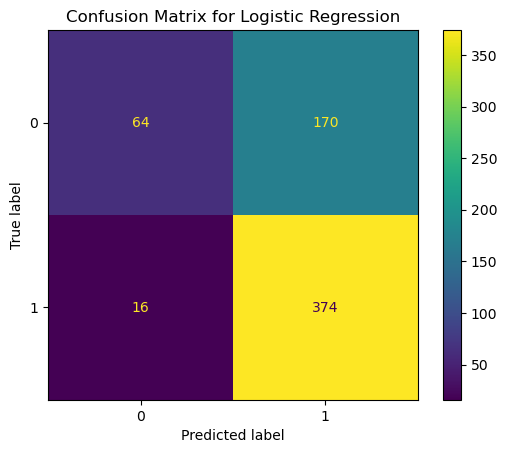

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model_test, X_test, y_test)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()


### Transformer

In [ ]:
from Transformer import Transformer

# latent_vectors = X_train.shape[0] # 5216 latent vectors
latent_dim = X_train.shape[1] # 64 dimensions of latent space
output_dim = 2

# Initialize the Transformer model
T = Transformer(input_dim = latent_dim, num_patches = 1, output_dim=output_dim, hidden_dim=latent_dim).to(device)

# Train the Transformer model
def train_transformer(model: Transformer, X_train, y_train, device, epochs=3, batch_size=32):
    X = torch.tensor(X_train, dtype=torch.float32).to(device)  # [vectors, dim]
    y = torch.tensor(y_train, dtype=torch.long).to(device)  # [labels]
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        i = 0
        # Simulates batch loading method without dataloader
        while i < X.shape[0]: # Simulates batch loading method without dataloader
            # Create batches
            x_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            optimizer.zero_grad()
            outputs = model(x_batch)  
            loss = criterion(outputs, y_batch)  
            loss.backward()  
            optimizer.step()  

            total_loss += loss.item()
            i += batch_size  

        print(f"Epoch {epoch + 1} - Loss: {total_loss / (X.shape[0] // batch_size):.4f}")



TypeError: __init__() missing 1 required positional argument: 'output_dim'

In [ ]:
train_transformer(T, X_train, y_train, device, epochs=5)

In [ ]:
# Test loop
def test_transformer(model: Transformer, X_test, y_test, device, batch_size=32):
    X = torch.tensor(X_test, dtype=torch.float32).to(device)  # [vectors, dim]
    y = torch.tensor(y_test, dtype=torch.long).to(device)  # [labels]
    X, y = X.to(device), y.to(device)
    
    y_preds = []
    y_trues = []
    
    model.eval()
    with torch.no_grad():
        i = 0
        while i < X.shape[0]: 
            # Create batches
            x_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            outputs = model(x_batch)  # (batch_size, num_classes)
            preds = outputs.argmax(dim=1)  # Predicted labels

            y_preds.append(preds)
            y_trues.append(y_batch)

            i += batch_size
            
    # 2. Concatenate all batches
    y_preds = torch.cat(y_preds).cpu().numpy()
    y_trues = torch.cat(y_trues).cpu().numpy()

    # 3. Calculate accuracy and classification report
    acc = accuracy_score(y_trues, y_preds)
    # report = classification_report(y_trues, y_preds)

    return acc

In [ ]:
test_transformer(T, X_test, y_test, device)